# Import

In [201]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV

# Day

### Load Dataset

In [202]:
# Load daily dataset
day_url = "https://raw.githubusercontent.com/michaeldavidsinn/csvml/refs/heads/main/day.csv"
day_df = pd.read_csv(day_url)

In [203]:
# Show dataset
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### Pre-Processing

In [204]:
# Show missing values
print(day_df.isnull().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [205]:
# Show info
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [206]:
# Describe data
day_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [207]:
# Convert 'dteday' to datetime format and set index
day_df['dteday'] = pd.to_datetime(day_df['dteday'])
day_df.set_index('dteday', inplace=True)

In [208]:
# Selected features for daily modeling
selected_features = ['temp', 'hum', 'windspeed', 'season', 'weathersit', 'yr', 'mnth', 'holiday', 'weekday', 'workingday']

In [209]:
# Scale the features for XGBoost (daily data)
# scaler = StandardScaler()
# day_df[selected_features] = scaler.fit_transform(day_df[selected_features])

### Visualization

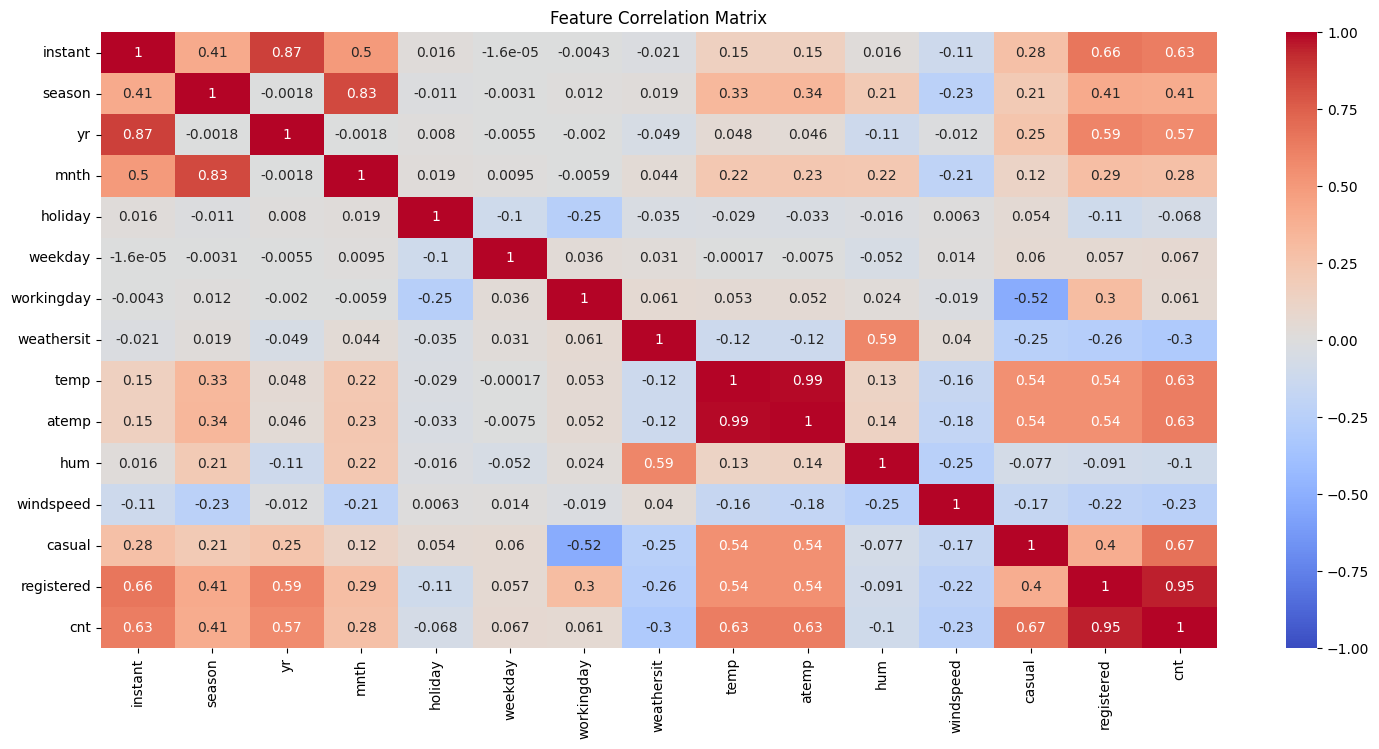

In [210]:
# Visualize using Correlation Matrix
correlation_matrix = day_df.corr()

plt.figure(figsize=(18, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

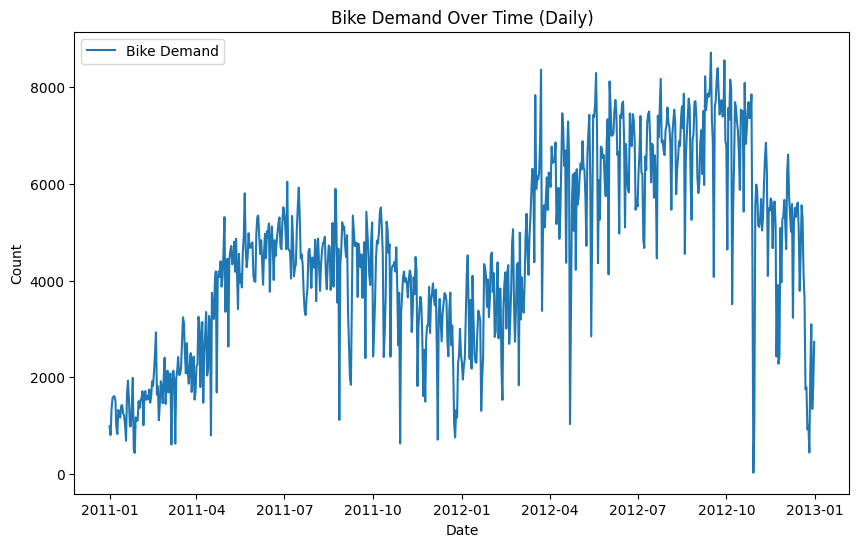

In [211]:
# Visualize the bike demand data (daily)
plt.figure(figsize=(10, 6))
plt.plot(day_df['cnt'], label="Bike Demand")
plt.title("Bike Demand Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()

### Processing

In [212]:
# SARIMAX model fitting (daily)
sarimax_model = SARIMAX(day_df['cnt'],
                        exog=day_df[selected_features],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12),  # Monthly seasonality
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results = sarimax_model.fit()

sarimax_predictions = results.predict(start=day_df.index[0], end=day_df.index[-1], exog=day_df[selected_features])
residuals = day_df['cnt'] - sarimax_predictions


/Users/mds/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/mds/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92244D+00    |proj g|=  1.11536D-01

At iterate    5    f=  7.87567D+00    |proj g|=  3.68098D-02

At iterate   10    f=  7.87296D+00    |proj g|=  3.92425D-03

At iterate   15    f=  7.87292D+00    |proj g|=  2.51279D-03

At iterate   20    f=  7.87240D+00    |proj g|=  3.80934D-02

At iterate   25    f=  7.81678D+00    |proj g|=  2.63861D-01

At iterate   30    f=  7.75967D+00    |proj g|=  3.42630D-02

At iterate   35    f=  7.75829D+00    |proj g|=  5.47103D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [213]:
X = day_df[selected_features]
y = residuals.dropna()

In [214]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
xgb_model = XGBRegressor(random_state=42)

In [215]:
# Perform GridSearch 
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X, y)
best_xgb_model = grid_search.best_estimator_
print(f"Best XGBoost Parameters (Daily): {grid_search.best_params_}")

Best XGBoost Parameters (Daily): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [216]:
# Predict residuals using tuned XGBoost model (daily)
xgb_residual_predictions = best_xgb_model.predict(X)

In [217]:
day_df[selected_features]

,temp,hum,windspeed,season,weathersit,yr,mnth,holiday,weekday,workingday
dteday,,,,,,,,,,
2011-01-01,0.344167,0.805833,0.160446,1,2,0,1,0,6,0
2011-01-02,0.363478,0.696087,0.248539,1,2,0,1,0,0,0
2011-01-03,0.196364,0.437273,0.248309,1,1,0,1,0,1,1
2011-01-04,0.200000,0.590435,0.160296,1,1,0,1,0,2,1
2011-01-05,0.226957,0.436957,0.186900,1,1,0,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...
2012-12-27,0.254167,0.652917,0.350133,1,2,1,12,0,4,1
2012-12-28,0.253333,0.590000,0.155471,1,2,1,12,0,5,1
2012-12-29,0.253333,0.752917,0.124383,1,2,1,12,0,6,0


### Evaluation

In [218]:
# Predict using SARIMAX and XGBoost for the entire dataset (daily)
sarimax_predictions_full = results.predict(start=day_df.index[0], end=day_df.index[-1], exog=day_df[selected_features])
xgb_residual_predictions_full = best_xgb_model.predict(day_df[selected_features])

In [219]:
# Combine SARIMAX and XGBoost predictions (daily)
final_predictions = sarimax_predictions_full + xgb_residual_predictions_full

In [220]:
# Evaluate combined model (daily)
mae_combined = mean_absolute_error(day_df['cnt'], final_predictions)
mse_combined = mean_squared_error(day_df['cnt'], final_predictions)
r2_combined = r2_score(day_df['cnt'], final_predictions)
print(f"Combined Model MAE (Daily): {mae_combined:.2f}")
print(f"Combined Model MSE (Daily): {mse_combined:.2f}")
print(f"Combined Model R2 (Daily): {r2_combined:.2f}")

Combined Model MAE (Daily): 478.86
Combined Model MSE (Daily): 437450.87
Combined Model R2 (Daily): 0.88


### Model Result

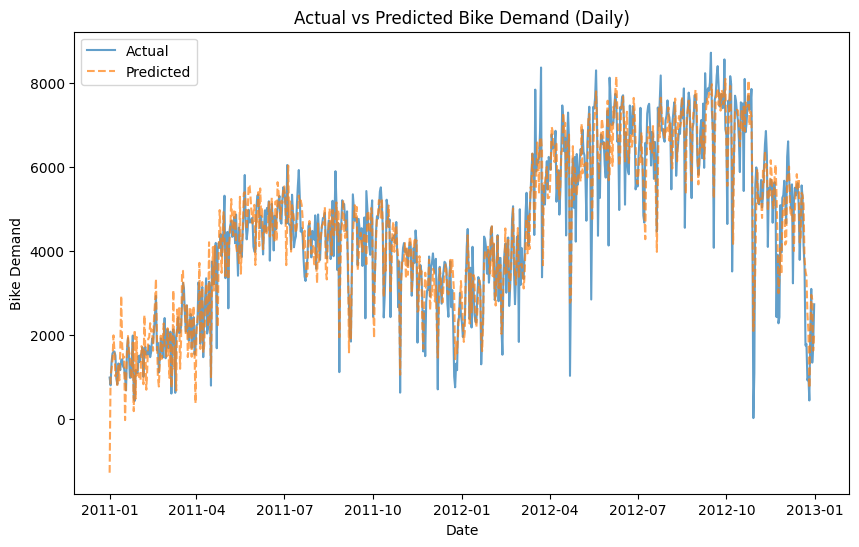

In [221]:
# Visualize actual vs predicted values (daily)
plt.figure(figsize=(10, 6))
plt.plot(day_df['cnt'], label="Actual", alpha=0.7)
plt.plot(final_predictions, label="Predicted", linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted Bike Demand (Daily)")
plt.xlabel("Date")
plt.ylabel("Bike Demand")
plt.legend()
plt.show()

# Hour

### Load Dataset

In [222]:
# Load hourly dataset
hour_url = "https://raw.githubusercontent.com/michaeldavidsinn/csvml/refs/heads/main/hour.csv"
hour_df = pd.read_csv(hour_url)

In [223]:
# Show dataset
hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Pre-Processing

In [224]:
# Show missing values
print(hour_df.isnull().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [225]:
# Show info
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [226]:
# Describe data
hour_df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [227]:
# Convert 'dteday' to datetime format and set datetime index (hourly)
hour_df['dteday'] = pd.to_datetime(hour_df['dteday'])
hour_df['datetime'] = hour_df['dteday'] + pd.to_timedelta(hour_df['hr'], unit='h')
hour_df.set_index('datetime', inplace=True)

In [228]:
# Ensure sample size is not larger than the dataset
sample_size = 100000  # Adjust as needed
total_rows = len(hour_df)
sample_size = min(sample_size, total_rows)

In [229]:
# Sample the data
hour_df_sampled = hour_df.sample(n=sample_size, random_state=42)

In [230]:
# Selected features for hourly modeling
selected_features_hour = ['temp', 'hum', 'windspeed', 'season', 'weathersit', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'hr']

In [231]:
# Scale the features for XGBoost (daily data)
scaler = StandardScaler()
hour_df[selected_features] = scaler.fit_transform(hour_df[selected_features])

### Visualization

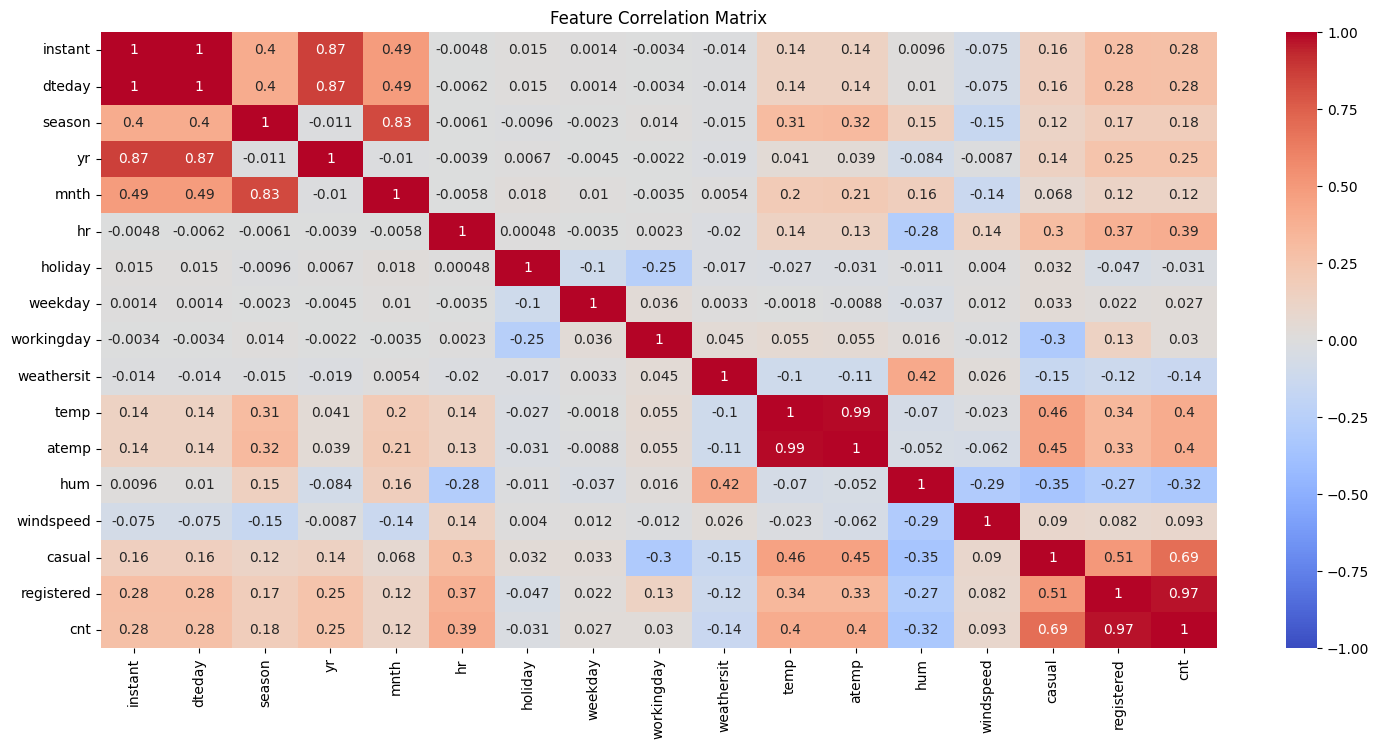

In [232]:
# Visualize using Correlation Matrix
correlation_matrix = hour_df.corr()

plt.figure(figsize=(18, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

### Processing

In [233]:
# Split data into training and testing sets (hourly data)
X = hour_df_sampled[selected_features_hour]
y = hour_df_sampled['cnt']

In [234]:
# XGBoost model fitting (hourly)
xgb_model_hour = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model_hour.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [235]:
# Predict using XGBoost (hourly)
xgb_predictions_hour = xgb_model_hour.predict(X)

### Evaluation

In [236]:
# Evaluate XGBoost (hourly)
xgb_mae_hour = mean_absolute_error(y, xgb_predictions_hour)
xgb_mse_hour = mean_squared_error(y, xgb_predictions_hour)
xgb_r2_hour = r2_score(y, xgb_predictions_hour)

print(f"XGBoost MAE (Hourly): {xgb_mae_hour:.2f}")
print(f"XGBoost MSE (Hourly): {xgb_mse_hour:.2f}")
print(f"XGBoost R2 (Hourly): {xgb_r2_hour:.2f}")

XGBoost MAE (Hourly): 27.99
XGBoost MSE (Hourly): 1886.66
XGBoost R2 (Hourly): 0.94


### Model Result

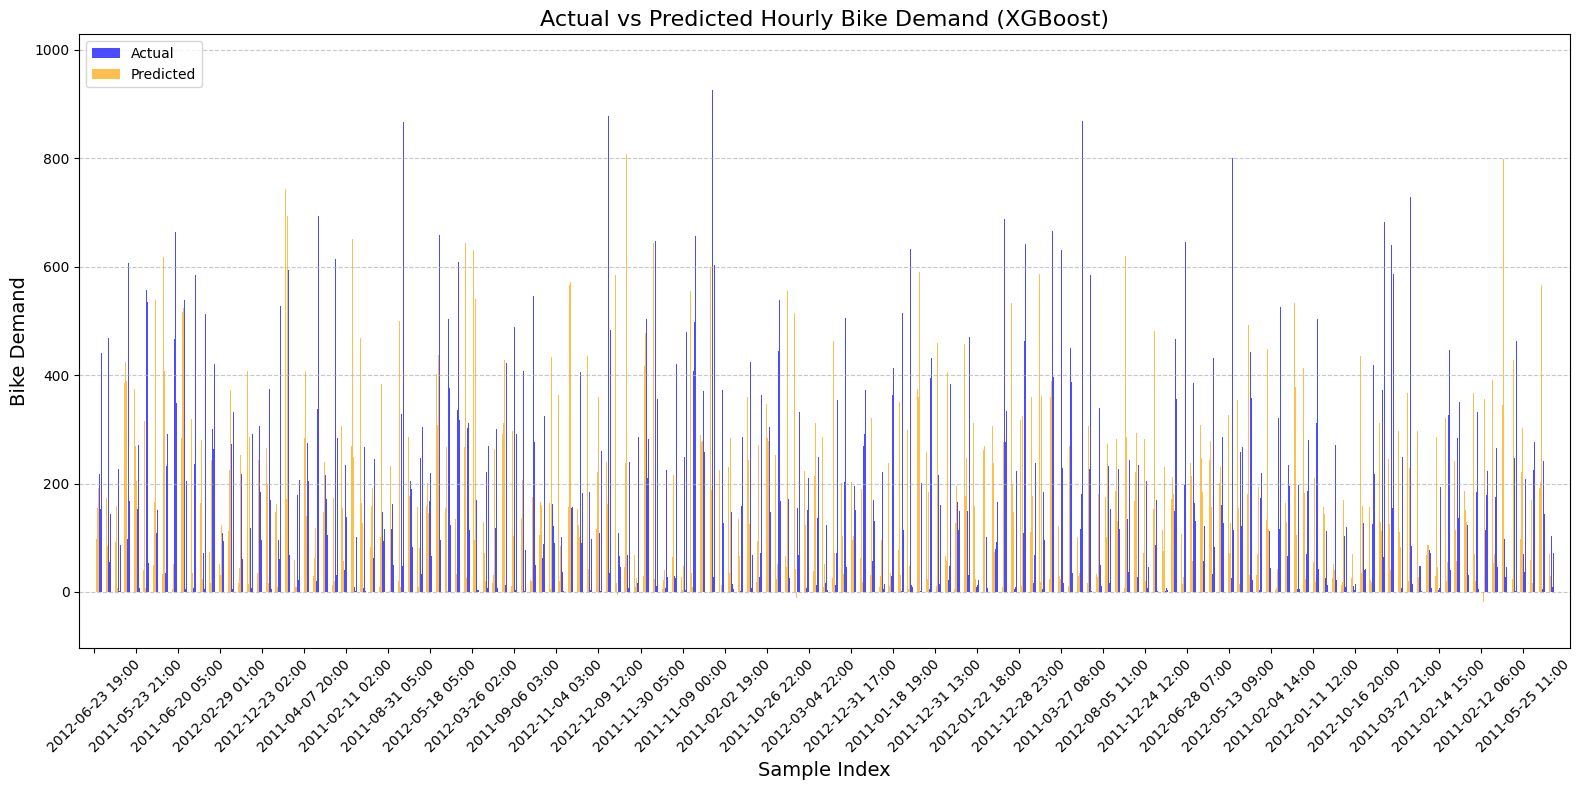

In [237]:
# Visualize actual vs predicted values (hourly)
index = np.arange(len(y))

step = 500  # Frekuensi label 
bar_width = 0.3

plt.figure(figsize=(16, 8))
plt.bar(index, y, width=bar_width, label="Actual", alpha=0.7, color='blue')
plt.bar(index + bar_width, xgb_predictions_hour, width=bar_width, label="Predicted", alpha=0.7, color='orange')

plt.title("Actual vs Predicted Hourly Bike Demand (XGBoost)", fontsize=16)
plt.xlabel("Sample Index", fontsize=14)
plt.ylabel("Bike Demand", fontsize=14)
plt.xticks(index[::step], y.index.strftime('%Y-%m-%d %H:%M')[::step], rotation=45)
plt.margins(x=0.01)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [238]:
# Convert to DataFrame
results_df = pd.DataFrame({
    'Time': y.index.strftime('%Y-%m-%d %H:%M'),
    'Actual': y.values,
    'Predicted': xgb_predictions_hour
})

results_df.head()

,Time,Actual,Predicted
0,2012-06-23 19:00,425,442.154724
1,2012-01-02 20:00,88,93.389763
2,2011-10-28 02:00,4,17.167749
3,2012-05-29 19:00,526,554.864502
4,2011-01-20 00:00,13,11.408092


In [239]:
# Convert to csv
results_df.to_csv("finalhour.csv", index=False)
print("Tabel has been exported to csv")

Tabel has been exported to csv
